In [1]:
#Competition: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
import numpy as np
import pandas as pd
import random, string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

In [2]:
train_data = pd.read_csv('train.csv')
#test_data = pd.read_csv('test.csv')

train_data, test_data = train_test_split(train_data, test_size=0.1)

train_data=train_data.set_index(train_data['Id'])
test_data=test_data.set_index(test_data['Id'])

train_data[:5]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
555,555,60,RL,85.0,10625,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2008,WD,Normal,284000
1051,1051,20,RL,73.0,8993,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,New,Partial,176485
235,235,60,RL,NaN,7851,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,216500
1124,1124,20,RL,50.0,9405,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,118000
1025,1025,20,RL,NaN,15498,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,COD,Abnorml,287000


Numerical columns:
- LotFrontage
- LotArea
- YearBuilt TODO create age from this.
- YearRemodAdd TODO create age from this.

Ignored:
- LandContour, LandSlope, Exterior2nd, 

I stopped at MasVnrArea
    

In [3]:
# Clean data.
train_data['Alley'].fillna('-1', inplace=True)
train_data['MasVnrType'].fillna('-1', inplace=True)
test_data['Alley'].fillna('-1', inplace=True)
test_data['MasVnrType'].fillna('-1', inplace=True)

# To check group-by count
#train_data['LotShape'].groupby(train_data['LotShape']).count()

In [4]:
categorical_columns = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LotConfig', 'Neighborhood',
    'Condition1', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 
    'Exterior1st', 'MasVnrType']

def prepare_train(X):
    train_X = pd.DataFrame(X[[]], index=X.index)
    
    transformers=[]    
    for column in categorical_columns:  
        enc = OneHotEncoder(handle_unknown = 'ignore')
        train_X = train_X.join( 
            pd.DataFrame(
                data=enc.fit_transform(X[[column]]).toarray(), index=X.index, 
                columns=enc.get_feature_names()),
            rsuffix='_'+column
        )
        transformers.append(enc)

    return train_X, transformers

def prepare_test(X, transformers):
    test_X = pd.DataFrame(X[[]], index=X.index)
    
    for column, enc in zip(categorical_columns, transformers):
        test_X = test_X.join( 
            pd.DataFrame(data=enc.transform(X[[column]]).toarray(), index=X.index,
                         columns=enc.get_feature_names()),
            rsuffix='_'+column
        )
    return test_X

X_train, transformers = prepare_train(train_data)
X_test = prepare_test(test_data, transformers)

Y_train = train_data['SalePrice']
Y_test = test_data['SalePrice']

X_train[:3]

,x0_20,x0_30,x0_40,x0_45,x0_50,x0_60,x0_70,x0_75,x0_80,x0_85,...,x0_Stone,x0_Stucco,x0_VinylSd,x0_Wd Sdng,x0_WdShing,x0_-1_MasVnrType,x0_BrkCmn,x0_BrkFace_MasVnrType,x0_None,x0_Stone_MasVnrType
Id,,,,,,,,,,,,,,,,,,,,,
555,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1051,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
235,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


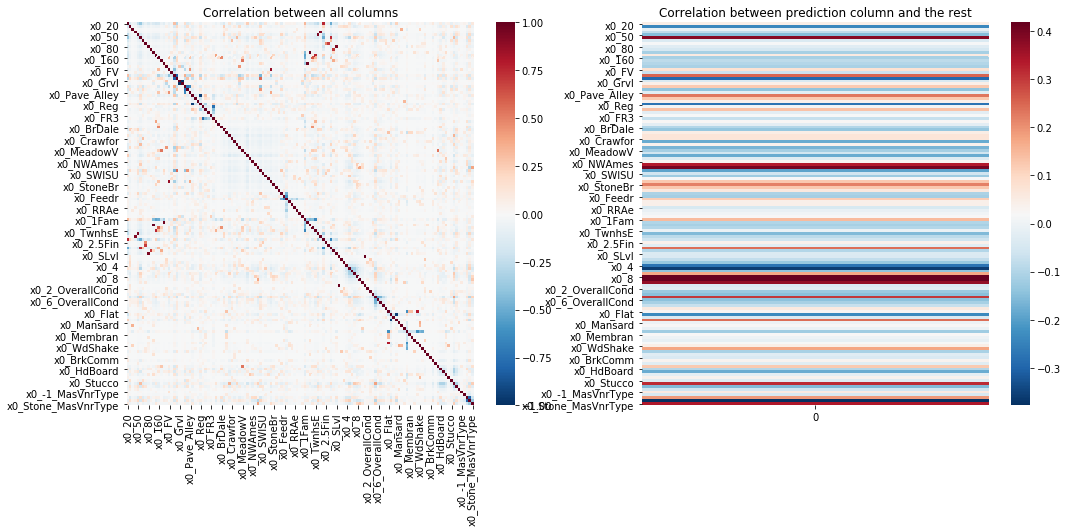

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
fig.tight_layout(pad=5) 

ax1.title.set_text('Correlation between all columns')
sns.heatmap(X_train.corr(), ax=ax1, cmap="RdBu_r")

ax2.title.set_text('Correlation between prediction column and the rest')
sns.heatmap(X_train.corrwith(train_data['SalePrice']).to_frame(), ax=ax2, cmap="RdBu_r")
plt.show()

# Mostly white in the first chart means that there is little correlation between the columns. 
# This is good because it means that they carry unique information.
# But in second chart it can be seen that there is correlation between the column to predict and the input columns;


In [15]:
def train(X_train, Y_train, design):
    model = MLPRegressor(solver='sgd', hidden_layer_sizes=design, #max_iter=10, 
                         verbose=10,
                          learning_rate='adaptive', 
                          learning_rate_init=0.001
                         )
    model.fit(X_train, Y_train)
    return model 

model = train(X_train, Y_train, design=(10))

train_RMSE = mean_squared_error(Y_train, model.predict(X_train))
print('train_RMSE={}, '.format(str(train_RMSE)))

test_RMSE = mean_squared_error(Y_test, model.predict(X_test))
print('test_RMSE={}, '.format(str(test_RMSE)))

Iteration 1, loss = 18070221453.22696304
Iteration 2, loss = 18370051092.44938660
Iteration 3, loss = 16850961967.38981628
Iteration 4, loss = 15214564270.18905830
Iteration 5, loss = 13640567854.07625771
Iteration 6, loss = 12219204969.30486488
Iteration 7, loss = 10972511586.42189980
Iteration 8, loss = 9869612439.88649940
Iteration 9, loss = 8929574479.33810043
Iteration 10, loss = 8115443946.46228695
Iteration 11, loss = 7414722432.98466015
Iteration 12, loss = 6815336854.56589603
Iteration 13, loss = 6303897623.91212749
Iteration 14, loss = 5860758566.23202038
Iteration 15, loss = 5491350425.41222572
Iteration 16, loss = 5163616272.42240620
Iteration 17, loss = 4888790675.44501781
Iteration 18, loss = 4650085165.52771759
Iteration 19, loss = 4447709762.84337521
Iteration 20, loss = 4274907158.11875582
Iteration 21, loss = 4119891899.94436407
Iteration 22, loss = 3995393456.86308432
Iteration 23, loss = 3887329372.51762486
Iteration 24, loss = 3794060297.52243137
Iteration 25, loss

Iteration 189, loss = 3235805416.41531754
Iteration 190, loss = 3235805421.31922913
Iteration 191, loss = 3235805435.02910566
Iteration 192, loss = 3235805420.71432257
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Learning rate too small. Stopping.
train_RMSE=6468458889.886014, 
test_RMSE=4854570548.295029, 
